In [1]:
import numpy as np
from scipy import signal
from scipy import fftpack
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import f06_postpro as f06
import dat_tools as dat
import rfp
import oma
import mac

### Funciones de transferencia nodales por simulación

In [2]:
freq, accel, nodes = f06.read_nodes_accel('C:\RUNRUN\sate_corners_sinex.f06')
coords = dat.read_node_coords('C:\RUNRUN\sate_corners_sinex.dat', nodes)

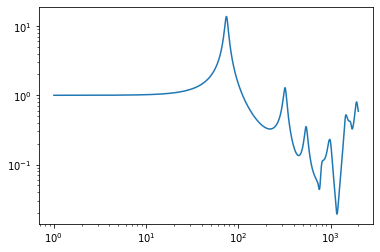

In [3]:
plt.loglog(freq, np.abs(accel['15'][:,0]))

In [4]:
# Transfer matrix
input_node = 1
input_node_str = str(input_node)

TF_dict = accel.copy()
# Delete input node
if input_node_str in TF_dict: del TF_dict[input_node_str]

total_nodes = len(TF_dict.keys())
dof_per_node = 3
total_dofs = total_nodes * dof_per_node
TF = np.zeros((len(freq), total_dofs), dtype=complex)
node_order = dict()
col = 0
for node_str in TF_dict.keys():
    node_order[node_str] = col
    TF[:,col:col+3] = TF_dict[node_str]
    col += 3

In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:total_dofs]

### Ruido blanco en la base

In [6]:
g_rms = 1
t_end = 120
f_s = 4000
delta_t = 1/f_s
t = np.linspace(0, t_end, int(t_end/delta_t))
Ug_time = g_rms * np.random.normal(size=len(t))

In [7]:
# fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(t, Ug_time, color='k', marker='')
# plt.title('Historia de aceleraciones en la base')
# plt.xlabel('Tiempo [s]')
# plt.ylabel('Aceleración [g]')
# ax.grid(True, markevery=1) 

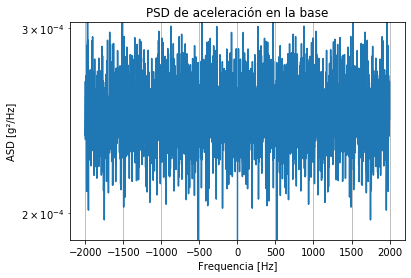

In [59]:
# PSD de aceleraciones en la base
nperseg = 4096
Ug_psd_freq, Ug_psd = signal.welch(Ug_time, 
                      fs=f_s, # sample rate
                      window='hamming', # apply a Hanning window before taking the DFT
                      nperseg=nperseg, # compute periodograms of 256-long segments of x
                      detrend='constant', # detrend x by subtracting the mean)
                      return_onesided=False)

plt.figure()
plt.semilogy(Ug_psd_freq, Ug_psd)
plt.title('PSD de aceleración en la base')
plt.ylim([np.min(Ug_psd[1:]), np.max(Ug_psd[1:])])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('ASD [g²/Hz]')
plt.grid()
plt.show()

In [60]:
len(Ug_psd)

4096

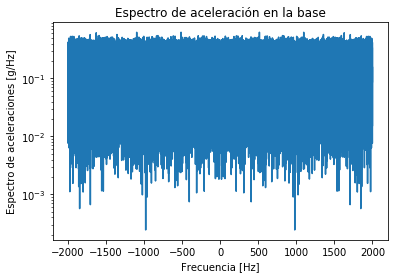

In [61]:
# Transformada de Fourier de aceleraciones en la base
Ug_fft_twosided = np.fft.fft(Ug_time) * delta_t
Ug_fft_freq_twosided = np.fft.fftfreq(len(t), d=delta_t)
# onesided_2kHz_size = len(Ug_fft_twosided)//4
# delta_t_2kHz = delta_t * 2
# Ug_fft_freq = Ug_fft_freq_twosided[:onesided_2kHz_size]
# Ug_fft = 2*Ug_fft_twosided[:onesided_2kHz_size]
Ug_fft = Ug_fft_twosided
Ug_fft_freq = Ug_fft_freq_twosided
plt.figure()
plt.semilogy(Ug_fft_freq, abs(Ug_fft))
plt.title('Espectro de aceleración en la base')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Espectro de aceleraciones [g/Hz]')
plt.show()

In [62]:
Ug_fft_freq

array([ 0.        ,  0.00833333,  0.01666667, ..., -0.025     ,
       -0.01666667, -0.00833333])

### Respuestas nodales

In [63]:
# Interpolacion de transferencias las frecuencias de excitación
TF_inter = np.zeros((len(Ug_fft_freq), TF.shape[1]), dtype=complex)
for dof in range(TF.shape[1]):
    TF_inter[:,dof] = 2*np.interp(Ug_fft_freq, freq, TF[:,dof])

In [64]:
# Espectros de respuesta
ddotY_fft = (TF_inter.T*Ug_fft).T

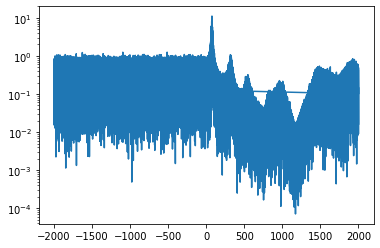

In [65]:
plt.semilogy(Ug_fft_freq, np.abs(ddotY_fft[:,15]))

In [66]:
# Respuestas temporales
ddotY_time = fftpack.ifft(ddotY_fft, axis=0)

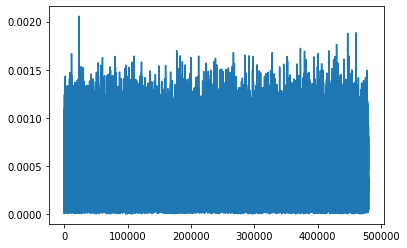

In [67]:
plt.plot(np.abs(ddotY_time[:,15]))

## GRFP

#### Estimador H1 de la FRF

In [68]:
S_xf = np.zeros((nperseg, total_dofs), dtype=complex)
for dof in range(total_dofs):
        f_Sxf, S_xf[:, dof] = signal.csd(ddotY_time[:, dof], Ug_time,
                                               fs=f_s,
                                               window='hanning',
                                               nperseg=nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

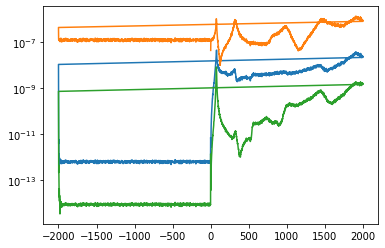

In [69]:
plt.semilogy(f_Sxf, np.abs(S_xf[:,-4:-1]))

In [70]:
f_H = f_Sxf[:len(f_Sxf)//2]
H1 = S_xf[:len(f_H),:]/Ug_psd[:len(f_H), np.newaxis]
# H1 = S_xf/Ug_psd[:, np.newaxis]
mode_ind_H1 = np.array([m for m in signal.argrelmax(np.abs(H1[:len(f_H)//4, -3]), order=30)]).flatten()

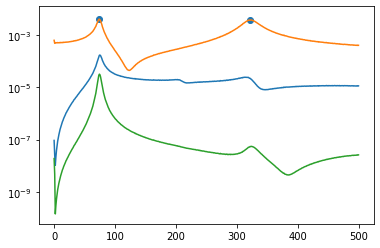

In [71]:
plt.semilogy(f_H[:len(f_H)//4], np.abs(H1[:len(f_H)//4,-4:-1]))
plt.scatter(f_H[mode_ind_H1], np.abs(H1[mode_ind_H1,-3]))

In [72]:
f_H[mode_ind_H1]

array([ 74.21875  , 321.2890625])

In [73]:
n_modes = 2
m = 2*n_modes-1
n = 2*n_modes
modal_params, alpha = rfp.rfp(H1[:len(f_H)//8,-3], 2*np.pi*f_H[:len(f_H)//8],n,m)

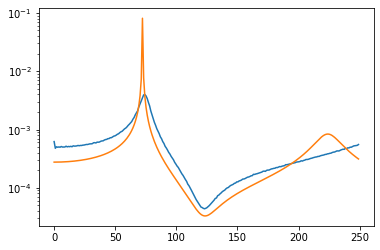

In [74]:
plt.semilogy(f_H[:len(f_H)//8], np.abs(H1[:len(f_H)//8,-3]))
plt.semilogy(f_H[:len(f_H)//8], np.abs(alpha))

In [75]:
modal_params

[array([ 72.30842067, 224.10410828]),
 array([-0.00110408,  0.04524926]),
 array([ 41.85646684, 148.7701602 ]),
 array([-3.03380821,  3.03825065])]

In [76]:
n_modes = 4
m = 2*n_modes-1
n = 2*n_modes
denom, denom_coeff = rfp.grfp_denominator(H1[:len(f_H)//4,:], 2*np.pi*f_H[:len(f_H)//4],n,m)

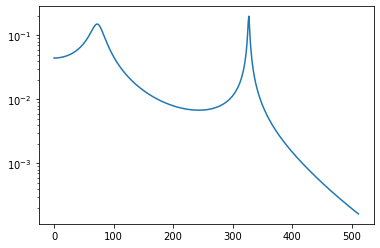

In [77]:
plt.semilogy(np.abs(1/denom))

In [78]:
[freq_n, xi_n, modal_mag_n, modal_ang_n], alpha1 = rfp.grfp_parameters(H1[:len(f_H)//4,:], 2*np.pi*f_H[:len(f_H)//4], denom, denom_coeff, m)
freq_n

array([ 72.32310309, 319.27021803, 390.66753138])

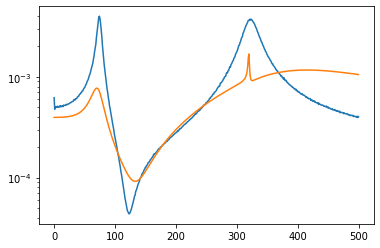

In [79]:
plt.semilogy(f_H[:len(f_H)//4], np.abs(H1[:len(f_H)//4,-3]))
plt.semilogy(f_H[:len(f_H)//4], np.abs(alpha1[:,-3]))

Max value off diagonal: 0.223


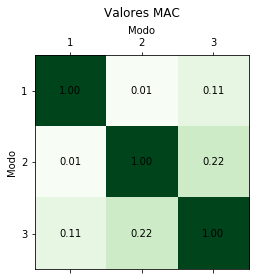

In [80]:
modes_grfp = (modal_mag_n*np.exp(1j*modal_ang_n)).T
MAC_grfp = mac.get_MAC_matrix(modes_grfp, modes_grfp)
mac.plot_MAC(MAC_grfp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_grfp)))

## CFDD

#### Matriz de densidades espectrales de la respuesta

In [81]:
S_xx_twoside = np.zeros((nperseg, total_dofs, total_dofs), dtype=complex)
for dof1 in range(total_dofs):
    for dof2 in range(total_dofs):
        f_S_twoside, S_xx_twoside[:, dof1, dof2] = signal.csd(ddotY_time[:, dof1], ddotY_time[:, dof2],
                                                               fs=f_s,
                                                               window='hanning',
                                                               nperseg=nperseg,
                                                               detrend='constant',
                                                               axis=0,
                                                               return_onesided=False)
f_S = f_S_twoside[:len(f_S_twoside)//2]
S_xx = S_xx_twoside[:len(f_S),:,:]

In [82]:
# Extraigo frecuencias y formas de modo por SVD
u_fdd, s_fdd, vh_fdd = np.linalg.svd(S_xx)

# Maximos del primer valor singular
mode_ind_fdd = np.array([m for m in signal.argrelmax(s_fdd[:len(f_S)//4, 0], order=70)]).flatten()

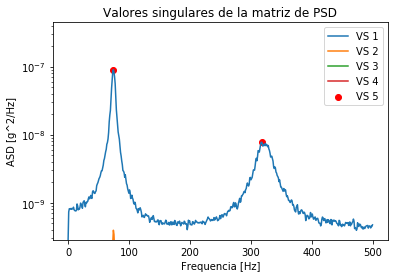

In [83]:
plt.semilogy(f_S[:len(f_S)//4], s_fdd[:len(f_S)//4, :4])
plt.ylim([np.min(s_fdd[:, 0]), None])
plt.scatter(f_S[mode_ind_fdd[:4]],
            abs(s_fdd[mode_ind_fdd[:4], 0]),
            color='r')
plt.title('Valores singulares de la matriz de PSD')
plt.ylabel('ASD [g^2/Hz]')
plt.xlabel('Frequencia [Hz]')
lgnd  = ['VS {}'.format(col+1) for col in range(s_fdd.shape[1])]
plt.legend(lgnd, loc='upper right')
plt.show()

In [84]:
fdd_total_modes = 4
f_S[mode_ind_fdd[:fdd_total_modes]]

array([ 74.21875  , 317.3828125])

Max value off diagonal: 0.037


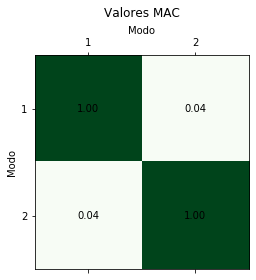

In [85]:
modes_fdd = u_fdd[mode_ind_fdd[:fdd_total_modes],:,0].T
MAC_fdd = mac.get_MAC_matrix(modes_fdd, modes_fdd)
mac.plot_MAC(MAC_fdd, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_fdd)))

In [86]:
delta_pos = np.real(u_fdd[mode_ind_fdd[0],:,0].reshape((total_nodes, 3)))/max(np.abs(u_fdd[mode_ind_fdd[0],:,0]))

In [87]:
original = np.zeros((len(nodes), 3))
for node_idx in range(len(nodes)):
    original[node_idx,:] = coords[nodes[node_idx]]

deformed = original + 100*(np.concatenate((np.zeros((1,3)),delta_pos)))

In [88]:
connect = np.array([
    [],
])

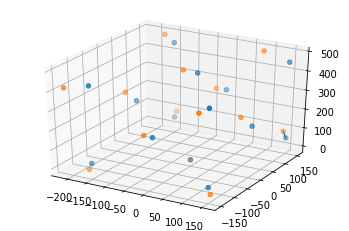

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(original[:,0],original[:,1],original[:,2])
ax.scatter(deformed[:,0],deformed[:,1],deformed[:,2])
ax.plot([original[1,0],deformed[1,0]],[original[1,1],deformed[1,1]],[original[1,2],deformed[1,2]])

C:\Users\rafa\projects\atelier\oma.py:121: RuntimeWarning: invalid value encountered in double_scalars
  w_n = 1/x[1]**0.25


Text(0, 0.5, 'PSD [g^2/Hz]')

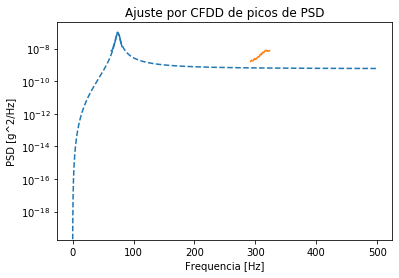

In [90]:
mac_th = 0.8
total_modes = 2
f_cfdd = np.zeros(total_modes)
xi_cfdd = np.zeros(total_modes)

freq_hat = np.linspace(0, f_S[len(f_S)//2-1], 4000)
psd_hat = np.zeros((freq_hat.size, total_modes))

for mode in range(total_modes):
    peak_idx = mode_ind_fdd[mode]
    efdd_idxes = oma.get_efdd_segment(u_fdd, peak_idx, mac_th)
    f_cfdd[mode], xi_cfdd[mode], psd_hat[:, mode] = oma.curve_fit_psd_peak(f_S, s_fdd[:, 0], efdd_idxes, freq_hat)
    
    plt.semilogy(f_S[efdd_idxes[0]:efdd_idxes[1]],
                 abs(s_fdd[efdd_idxes[0]:efdd_idxes[1], 0]),
                 color=colors[mode])
    plt.semilogy(freq_hat[:freq_hat.size//2],
                 abs(psd_hat[:freq_hat.size//2, mode]),
                 color=colors[mode],
                 linestyle='--')

plt.title('Ajuste por CFDD de picos de PSD')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('PSD [g^2/Hz]')
# plt.ylim([abs(s_fdd[efdd_idxes[1], 0]), None])

In [91]:
freq_hat

array([0.00000000e+00, 2.49818314e-01, 4.99636628e-01, ...,
       9.98523801e+02, 9.98773619e+02, 9.99023438e+02])

In [92]:
f_S

array([0.00000000e+00, 9.76562500e-01, 1.95312500e+00, ...,
       1.99707031e+03, 1.99804688e+03, 1.99902344e+03])